# EAST + CRAFT Greedy Merge Ensemble

## Setup & Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
from craft_text_detector import Craft
from shapely.geometry import Polygon
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set paths
EAST_MODEL_PATH = '../pretrained_weights/east/frozen_east_text_detection.pb'
CRAFT_MODEL_PATH = '../pretrained_weights/craft/craft_ic15_20k.pth'
IMAGES_DIR = Path('../archive/ch4_test_images')
GT_DIR = Path('../archive/ch4_test_localization_transcription_gt')
OUTPUT_DIR = Path('greedyfuse_outputs')
VIZ_DIR = Path('greedyfuse_visualizations')

# Create output directories
for dir_path in [OUTPUT_DIR / 'east', OUTPUT_DIR / 'craft', OUTPUT_DIR / 'ensemble', VIZ_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

# Comprehensive monkey patch for numpy compatibility with craft-text-detector
import craft_text_detector.craft_utils as craft_utils

# Patch: adjustResultCoordinates
original_adjustResultCoordinates = craft_utils.adjustResultCoordinates

def patched_adjustResultCoordinates(polys, ratio_w, ratio_h, ratio_net=2):
    """Patched version that handles numpy array creation properly"""
    if len(polys) > 0:
        # Don't convert to array first - process list directly
        for k in range(len(polys)):
            if polys[k] is not None:
                polys[k] *= (ratio_w * ratio_net, ratio_h * ratio_net)
    return polys

craft_utils.adjustResultCoordinates = patched_adjustResultCoordinates

# Patch numpy.array to handle heterogeneous sequences
_original_np_array = np.array

def _patched_np_array(arr_input, dtype=None, **kwargs):
    """Patched numpy array that uses object dtype for heterogeneous sequences"""
    try:
        return _original_np_array(arr_input, dtype=dtype, **kwargs)
    except ValueError as e:
        error_msg = str(e)
        if "inhomogeneous shape" in error_msg or "setting an array element with a sequence" in error_msg:
            # Use object dtype for heterogeneous arrays
            return _original_np_array(arr_input, dtype=object)
        raise

np.array = _patched_np_array

print("Imports and directories ready")
print("Comprehensive CRAFT numpy compatibility patches applied")

c:\Users\ASUS\anaconda3\envs\.py38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Imports and directories ready
Comprehensive CRAFT numpy compatibility patches applied


## Load East Model

In [2]:
def load_east_model(model_path):
    """Load EAST model using OpenCV DNN"""
    net = cv2.dnn.readNet(model_path)
    print(f"EAST model loaded from {model_path}")
    return net

east_net = load_east_model(EAST_MODEL_PATH)

EAST model loaded from ../pretrained_weights/east/frozen_east_text_detection.pb


## Load CRAFT Model (with compatibility fix)

In [3]:
# Workaround for torchvision compatibility issue
import sys
import torchvision.models.vgg as vgg_module

# Monkey patch model_urls if it doesn't exist
if not hasattr(vgg_module, 'model_urls'):
    vgg_module.model_urls = {
        'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth'
    }

def load_craft_model(model_path):
    """Load CRAFT model using craft-text-detector"""
    craft = Craft(
        output_dir=None,
        crop_type="poly",
        cuda=torch.cuda.is_available(),
        export_extra=False
    )
    
    # Load custom weights if provided
    if Path(model_path).exists():
        # Load state dict
        state_dict = torch.load(model_path, map_location='cpu')
        
        # Remove 'module.' prefix from keys (happens when model was trained with DataParallel)
        new_state_dict = {}
        for key, value in state_dict.items():
            if key.startswith('module.'):
                new_state_dict[key[7:]] = value  # Remove 'module.' prefix
            else:
                new_state_dict[key] = value
        
        craft.craft_net.load_state_dict(new_state_dict)
        print(f"CRAFT model loaded from {model_path}")
    else:
        print("CRAFT model loaded with default weights")
    
    return craft

craft_detector = load_craft_model(CRAFT_MODEL_PATH)

CRAFT model loaded from ../pretrained_weights/craft/craft_ic15_20k.pth


## EAST Inference Function

In [4]:
def detect_east(image_path, net, conf_threshold=0.5, nms_threshold=0.4):
    """
    Run EAST text detection on an image
    Returns: list of (polygon, confidence) tuples
    """
    image = cv2.imread(str(image_path))
    orig_h, orig_w = image.shape[:2]
    
    # EAST requires width and height to be multiples of 32
    new_w, new_h = 640, 640
    ratio_w = orig_w / new_w
    ratio_h = orig_h / new_h
    
    # Prepare blob
    blob = cv2.dnn.blobFromImage(image, 1.0, (new_w, new_h),
                                  (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net.setInput(blob)
    
    # Get output layers
    (scores, geometry) = net.forward(["feature_fusion/Conv_7/Sigmoid", 
                                      "feature_fusion/concat_3"])
    
    # Decode predictions
    rectangles = []
    confidences = []
    
    for y in range(scores.shape[2]):
        scores_data = scores[0, 0, y]
        x0_data = geometry[0, 0, y]
        x1_data = geometry[0, 1, y]
        x2_data = geometry[0, 2, y]
        x3_data = geometry[0, 3, y]
        angles_data = geometry[0, 4, y]
        
        for x in range(scores.shape[3]):
            score = scores_data[x]
            if score < conf_threshold:
                continue
            
            # Compute offset
            offset_x = x * 4.0
            offset_y = y * 4.0
            
            # Extract rotation angle and geometry
            angle = angles_data[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            
            h = x0_data[x] + x2_data[x]
            w = x1_data[x] + x3_data[x]
            
            # Compute bounding box coordinates
            end_x = int(offset_x + (cos * x1_data[x]) + (sin * x2_data[x]))
            end_y = int(offset_y - (sin * x1_data[x]) + (cos * x2_data[x]))
            start_x = int(end_x - w)
            start_y = int(end_y - h)
            
            rectangles.append((start_x, start_y, end_x, end_y))
            confidences.append(float(score))
    
    # Apply NMS
    boxes = np.array(rectangles)
    if len(boxes) == 0:
        return []
    
    indices = cv2.dnn.NMSBoxes(boxes.tolist(), confidences, conf_threshold, nms_threshold)
    
    # Convert to polygons in original image coordinates
    detections = []
    if len(indices) > 0:
        for i in indices.flatten():
            start_x, start_y, end_x, end_y = boxes[i]
            
            # Scale back to original image size
            start_x = int(start_x * ratio_w)
            start_y = int(start_y * ratio_h)
            end_x = int(end_x * ratio_w)
            end_y = int(end_y * ratio_h)
            
            # Create polygon (4 corners: top-left, top-right, bottom-right, bottom-left)
            polygon = np.array([
                [start_x, start_y],
                [end_x, start_y],
                [end_x, end_y],
                [start_x, end_y]
            ])
            
            detections.append((polygon, confidences[i]))
    
    return detections

print("EAST inference function ready")

EAST inference function ready


## CRAFT Inference Function (with numpy compatibility fix)

In [5]:
def detect_craft(image_path, craft_detector, text_threshold=0.7, link_threshold=0.4, low_text=0.4):
    """
    Run CRAFT text detection on an image
    Returns: list of (polygon, confidence) tuples
    """
    image = cv2.imread(str(image_path))
    
    # Run detection
    prediction_result = craft_detector.detect_text(str(image_path))
    
    detections = []
    
    # Extract polygons
    if 'boxes' in prediction_result:
        boxes = prediction_result['boxes']
        
        for box in boxes:
            # box is typically [[x1,y1], [x2,y2], [x3,y3], [x4,y4]]
            polygon = np.array(box).astype(int)
            
            # Use a default confidence or extract from prediction if available
            confidence = 0.9  # CRAFT doesn't always provide per-box confidence
            
            detections.append((polygon, confidence))
    
    return detections

print("CRAFT inference function ready")

CRAFT inference function ready


## Run EAST Inference on All Images

In [6]:
def save_detections(detections, output_path):
    """Save detections to file in format: x1,y1,x2,y2,x3,y3,x4,y4,confidence"""
    with open(output_path, 'w') as f:
        for polygon, conf in detections:
            # Flatten polygon coordinates
            coords = ','.join([str(int(c)) for point in polygon for c in point])
            f.write(f"{coords},{conf:.4f}\n")

# Run EAST on all images
print("Running EAST inference...")
east_results = {}
image_files = sorted(IMAGES_DIR.glob('*.jpg')) + sorted(IMAGES_DIR.glob('*.png'))

for img_path in image_files:
    print(f"  Processing {img_path.name}...")
    detections = detect_east(img_path, east_net)
    east_results[img_path.stem] = detections
    
    # Save to file
    output_path = OUTPUT_DIR / 'east' / f"{img_path.stem}.txt"
    save_detections(detections, output_path)

print(f"EAST inference complete: {len(east_results)} images processed")

Running EAST inference...
  Processing img_1.jpg...
  Processing img_10.jpg...
  Processing img_100.jpg...
  Processing img_101.jpg...
  Processing img_102.jpg...
  Processing img_103.jpg...
  Processing img_104.jpg...
  Processing img_105.jpg...
  Processing img_106.jpg...
  Processing img_107.jpg...
  Processing img_108.jpg...
  Processing img_109.jpg...
  Processing img_11.jpg...
  Processing img_110.jpg...
  Processing img_111.jpg...
  Processing img_112.jpg...
  Processing img_113.jpg...
  Processing img_114.jpg...
  Processing img_115.jpg...
  Processing img_116.jpg...
  Processing img_117.jpg...
  Processing img_118.jpg...
  Processing img_119.jpg...
  Processing img_12.jpg...
  Processing img_120.jpg...
  Processing img_121.jpg...
  Processing img_122.jpg...
  Processing img_123.jpg...
  Processing img_124.jpg...
  Processing img_125.jpg...
  Processing img_126.jpg...
  Processing img_127.jpg...
  Processing img_128.jpg...
  Processing img_129.jpg...
  Processing img_13.jpg...


## Run CRAFT Inference on All Images

In [7]:
# Run CRAFT on all images
print("Running CRAFT inference...")
craft_results = {}

for img_path in image_files:
    print(f"  Processing {img_path.name}...")
    detections = detect_craft(img_path, craft_detector)
    craft_results[img_path.stem] = detections
    
    # Save to file
    output_path = OUTPUT_DIR / 'craft' / f"{img_path.stem}.txt"
    save_detections(detections, output_path)

print(f"CRAFT inference complete: {len(craft_results)} images processed")

Running CRAFT inference...
  Processing img_1.jpg...
  Processing img_10.jpg...
  Processing img_100.jpg...
  Processing img_101.jpg...
  Processing img_102.jpg...
  Processing img_103.jpg...
  Processing img_104.jpg...
  Processing img_105.jpg...
  Processing img_106.jpg...
  Processing img_107.jpg...
  Processing img_108.jpg...
  Processing img_109.jpg...
  Processing img_11.jpg...
  Processing img_110.jpg...
  Processing img_111.jpg...
  Processing img_112.jpg...
  Processing img_113.jpg...
  Processing img_114.jpg...
  Processing img_115.jpg...
  Processing img_116.jpg...
  Processing img_117.jpg...
  Processing img_118.jpg...
  Processing img_119.jpg...
  Processing img_12.jpg...
  Processing img_120.jpg...
  Processing img_121.jpg...
  Processing img_122.jpg...
  Processing img_123.jpg...
  Processing img_124.jpg...
  Processing img_125.jpg...
  Processing img_126.jpg...
  Processing img_127.jpg...
  Processing img_128.jpg...
  Processing img_129.jpg...
  Processing img_13.jpg...

## Greedy Merge Ensemble

In [11]:
def polygon_iou(poly1, poly2):
    """
    Calculate IoU between two polygons using Shapely
    """
    try:
        p1 = Polygon(poly1)
        p2 = Polygon(poly2)
        
        if not p1.is_valid:
            p1 = p1.buffer(0)
        if not p2.is_valid:
            p2 = p2.buffer(0)
        
        intersection = p1.intersection(p2).area
        union = p1.union(p2).area
        
        if union == 0:
            return 0.0
        
        return intersection / union
    except:
        return 0.0

def greedy_merge(east_detections, craft_detections, iou_threshold=0.5):
    """
    Greedy merge algorithm:
    1. Match EAST and CRAFT boxes with IoU > threshold
    2. For matched pairs: average coordinates and take max confidence
    3. Keep unmatched boxes from both models
    """
    merged = []
    used_craft = set()
    
    # Step 1: Match EAST boxes with CRAFT boxes
    for east_poly, east_conf in east_detections:
        best_iou = 0
        best_match_idx = -1
        
        # Find best matching CRAFT box
        for craft_idx, (craft_poly, craft_conf) in enumerate(craft_detections):
            if craft_idx in used_craft:
                continue
            
            iou = polygon_iou(east_poly, craft_poly)
            if iou > best_iou:
                best_iou = iou
                best_match_idx = craft_idx
        
        # If good match found, merge the boxes
        if best_iou >= iou_threshold:
            craft_poly, craft_conf = craft_detections[best_match_idx]
            used_craft.add(best_match_idx)
            
            # Average the polygon coordinates
            merged_poly = ((east_poly.astype(float) + craft_poly.astype(float)) / 2).astype(int)
            
            # Take maximum confidence
            merged_conf = max(east_conf, craft_conf)
            
            merged.append((merged_poly, merged_conf))
        else:
            # Keep unmatched EAST box
            merged.append((east_poly, east_conf))
    
    # Step 2: Add unmatched CRAFT boxes
    for craft_idx, (craft_poly, craft_conf) in enumerate(craft_detections):
        if craft_idx not in used_craft:
            merged.append((craft_poly, craft_conf))
    
    return merged

print("Greedy merge function ready")

Greedy merge function ready


## Run Greedy Merge on All Images

In [12]:
# Run greedy merge
print("Running greedy merge ensemble...")
ensemble_results = {}

for img_stem in east_results.keys():
    print(f"  Merging {img_stem}...")
    
    east_dets = east_results[img_stem]
    craft_dets = craft_results[img_stem]
    
    merged_dets = greedy_merge(east_dets, craft_dets)
    ensemble_results[img_stem] = merged_dets
    
    # Save to file
    output_path = OUTPUT_DIR / 'ensemble' / f"{img_stem}.txt"
    save_detections(merged_dets, output_path)

print(f"Greedy merge complete: {len(ensemble_results)} images processed")

Running greedy merge ensemble...
  Merging img_1...
  Merging img_10...
  Merging img_100...
  Merging img_101...
  Merging img_102...
  Merging img_103...
  Merging img_104...
  Merging img_105...
  Merging img_106...
  Merging img_107...
  Merging img_108...
  Merging img_109...
  Merging img_11...
  Merging img_110...
  Merging img_111...
  Merging img_112...
  Merging img_113...
  Merging img_114...
  Merging img_115...
  Merging img_116...
  Merging img_117...
  Merging img_118...
  Merging img_119...
  Merging img_12...
  Merging img_120...
  Merging img_121...
  Merging img_122...
  Merging img_123...
  Merging img_124...
  Merging img_125...
  Merging img_126...
  Merging img_127...
  Merging img_128...
  Merging img_129...
  Merging img_13...
  Merging img_130...
  Merging img_131...
  Merging img_132...
  Merging img_133...
  Merging img_134...
  Merging img_135...
  Merging img_136...
  Merging img_137...
  Merging img_138...
  Merging img_139...
  Merging img_14...
  Mergin

## Evaluation Functions

In [14]:
def load_ground_truth(gt_path):
    """
    Load ground truth annotations
    Expected format: x1,y1,x2,y2,x3,y3,x4,y4,text (or just coordinates)
    """
    polygons = []
    
    if not gt_path.exists():
        return polygons
    
    with open(gt_path, 'r', encoding='utf-8-sig') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            
            parts = line.split(',')
            if len(parts) >= 8:
                try:
                    coords = [int(float(x)) for x in parts[:8]]
                    
                    # Skip if marked as "###" (difficult/ignored text in ICDAR)
                    if len(parts) > 8 and parts[8].strip() == '###':
                        continue
                    
                    polygon = np.array([
                        [coords[0], coords[1]],
                        [coords[2], coords[3]],
                        [coords[4], coords[5]],
                        [coords[6], coords[7]]
                    ])
                    polygons.append(polygon)
                except ValueError:
                    continue
    
    return polygons

def evaluate_detections(detections_dict, gt_dir, iou_threshold=0.5):
    """
    Evaluate detections against ground truth
    Returns: precision, recall, f1_score
    """
    total_gt = 0
    total_det = 0
    total_tp = 0
    
    for img_stem, detections in detections_dict.items():
        # Load ground truth - add "gt_" prefix to filename
        gt_path = gt_dir / f"gt_{img_stem}.txt"
        gt_polygons = load_ground_truth(gt_path)
        
        total_gt += len(gt_polygons)
        total_det += len(detections)
        
        # Match detections with ground truth
        matched_gt = set()
        
        for det_poly, det_conf in detections:
            for gt_idx, gt_poly in enumerate(gt_polygons):
                if gt_idx in matched_gt:
                    continue
                
                iou = polygon_iou(det_poly, gt_poly)
                if iou >= iou_threshold:
                    matched_gt.add(gt_idx)
                    total_tp += 1
                    break
    
    # Calculate metrics
    precision = total_tp / total_det if total_det > 0 else 0
    recall = total_tp / total_gt if total_gt > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'true_positives': total_tp,
        'total_detections': total_det,
        'total_ground_truth': total_gt
    }

print("Evaluation functions ready")

Evaluation functions ready


## Evaluate All Methods

In [16]:
print("\n" + "="*60)
print("EVALUATION RESULTS")
print("="*60)

# Evaluate EAST
print("\nEvaluating EAST...")
east_metrics = evaluate_detections(east_results, GT_DIR)

# Evaluate CRAFT
print("Evaluating CRAFT...")
craft_metrics = evaluate_detections(craft_results, GT_DIR)

# Evaluate Ensemble
print("Evaluating Ensemble (Greedy Merge)...")
ensemble_metrics = evaluate_detections(ensemble_results, GT_DIR)

print("\n Evaluation complete")


EVALUATION RESULTS

Evaluating EAST...
Evaluating CRAFT...
Evaluating Ensemble (Greedy Merge)...

 Evaluation complete


## Display Results Table

In [19]:
# Print results table
print("\n" + "="*80)
print("PERFORMANCE COMPARISON")
print("="*80)
print(f"{'Method':<20} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Detections':<12}")
print("-"*80)

for method_name, metrics in [('EAST', east_metrics), 
                              ('CRAFT', craft_metrics), 
                              ('Ensemble (Greedy)', ensemble_metrics)]:
    print(f"{method_name:<20} {metrics['precision']:<12.4f} {metrics['recall']:<12.4f} "
          f"{metrics['f1_score']:<12.4f} {metrics['total_detections']:<12}")

print("-"*80)
print(f"Total Ground Truth Instances: {east_metrics['total_ground_truth']}")
print("="*80)

# Calculate improvements
print("\nIMPROVEMENTS:")
print("-"*80)
if east_metrics['f1_score'] > 0:
    improvement_over_east = ((ensemble_metrics['f1_score'] - east_metrics['f1_score']) / 
                              east_metrics['f1_score'] * 100)
    print(f"Ensemble vs EAST: {improvement_over_east:+.2f}% F1-score improvement")

if craft_metrics['f1_score'] > 0:
    improvement_over_craft = ((ensemble_metrics['f1_score'] - craft_metrics['f1_score']) / 
                               craft_metrics['f1_score'] * 100)
    print(f"Ensemble vs CRAFT: {improvement_over_craft:+.2f}% F1-score improvement")
print("="*80)


PERFORMANCE COMPARISON
Method               Precision    Recall       F1-Score     Detections  
--------------------------------------------------------------------------------
EAST                 0.2999       0.2595       0.2783       1797        
CRAFT                0.4814       0.4497       0.4650       1940        
Ensemble (Greedy)    0.3471       0.5460       0.4244       3267        
--------------------------------------------------------------------------------
Total Ground Truth Instances: 2077

IMPROVEMENTS:
--------------------------------------------------------------------------------
Ensemble vs EAST: +52.52% F1-score improvement
Ensemble vs CRAFT: -8.74% F1-score improvement


## Visualization Functions

In [20]:
def draw_detections(image, detections, color=(0, 255, 0), thickness=2):
    """
    Draw detections on image
    """
    img_copy = image.copy()
    
    for polygon, conf in detections:
        pts = polygon.reshape((-1, 1, 2))
        cv2.polylines(img_copy, [pts], isClosed=True, color=color, thickness=thickness)
    
    return img_copy

def create_comparison_visualization(img_path, east_dets, craft_dets, ensemble_dets, output_path):
    """
    Create 3-row comparison visualization:
    Row 1: EAST output (red)
    Row 2: CRAFT output (blue)
    Row 3: Ensemble output (green)
    """
    # Load image
    image = cv2.imread(str(img_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Create visualizations
    img_east = draw_detections(image, east_dets, color=(255, 0, 0), thickness=2)
    img_craft = draw_detections(image, craft_dets, color=(0, 0, 255), thickness=2)
    img_ensemble = draw_detections(image, ensemble_dets, color=(0, 255, 0), thickness=2)
    
    # Create figure with 3 rows
    fig, axes = plt.subplots(3, 1, figsize=(15, 18))
    
    # EAST
    axes[0].imshow(img_east)
    axes[0].set_title(f'EAST Detection ({len(east_dets)} boxes)', fontsize=16, fontweight='bold')
    axes[0].axis('off')
    
    # CRAFT
    axes[1].imshow(img_craft)
    axes[1].set_title(f'CRAFT Detection ({len(craft_dets)} boxes)', fontsize=16, fontweight='bold')
    axes[1].axis('off')
    
    # Ensemble
    axes[2].imshow(img_ensemble)
    axes[2].set_title(f'Ensemble (Greedy Merge) ({len(ensemble_dets)} boxes)', 
                      fontsize=16, fontweight='bold')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.close()
    
    print(f"  Saved: {output_path.name}")

print("Visualization functions ready")

Visualization functions ready


## Generate Comparison Visualizations

In [21]:
print("\nGenerating comparison visualizations...")
print("="*60)

# Generate for first 5 images (or all if fewer)
num_visualizations = min(5, len(image_files))

for img_path in image_files[:num_visualizations]:
    img_stem = img_path.stem
    
    print(f"Creating visualization for {img_path.name}...")
    
    output_path = VIZ_DIR / f"{img_stem}_comparison.png"
    
    create_comparison_visualization(
        img_path,
        east_results[img_stem],
        craft_results[img_stem],
        ensemble_results[img_stem],
        output_path
    )

print("="*60)
print(f"Generated {num_visualizations} comparison visualizations")
print(f"  Saved to: {VIZ_DIR}")


Generating comparison visualizations...
Creating visualization for img_1.jpg...
  Saved: img_1_comparison.png
Creating visualization for img_10.jpg...
  Saved: img_10_comparison.png
Creating visualization for img_100.jpg...
  Saved: img_100_comparison.png
Creating visualization for img_101.jpg...
  Saved: img_101_comparison.png
Creating visualization for img_102.jpg...
  Saved: img_102_comparison.png
Generated 5 comparison visualizations
  Saved to: greedyfuse_visualizations


## Display Sample Visualizations

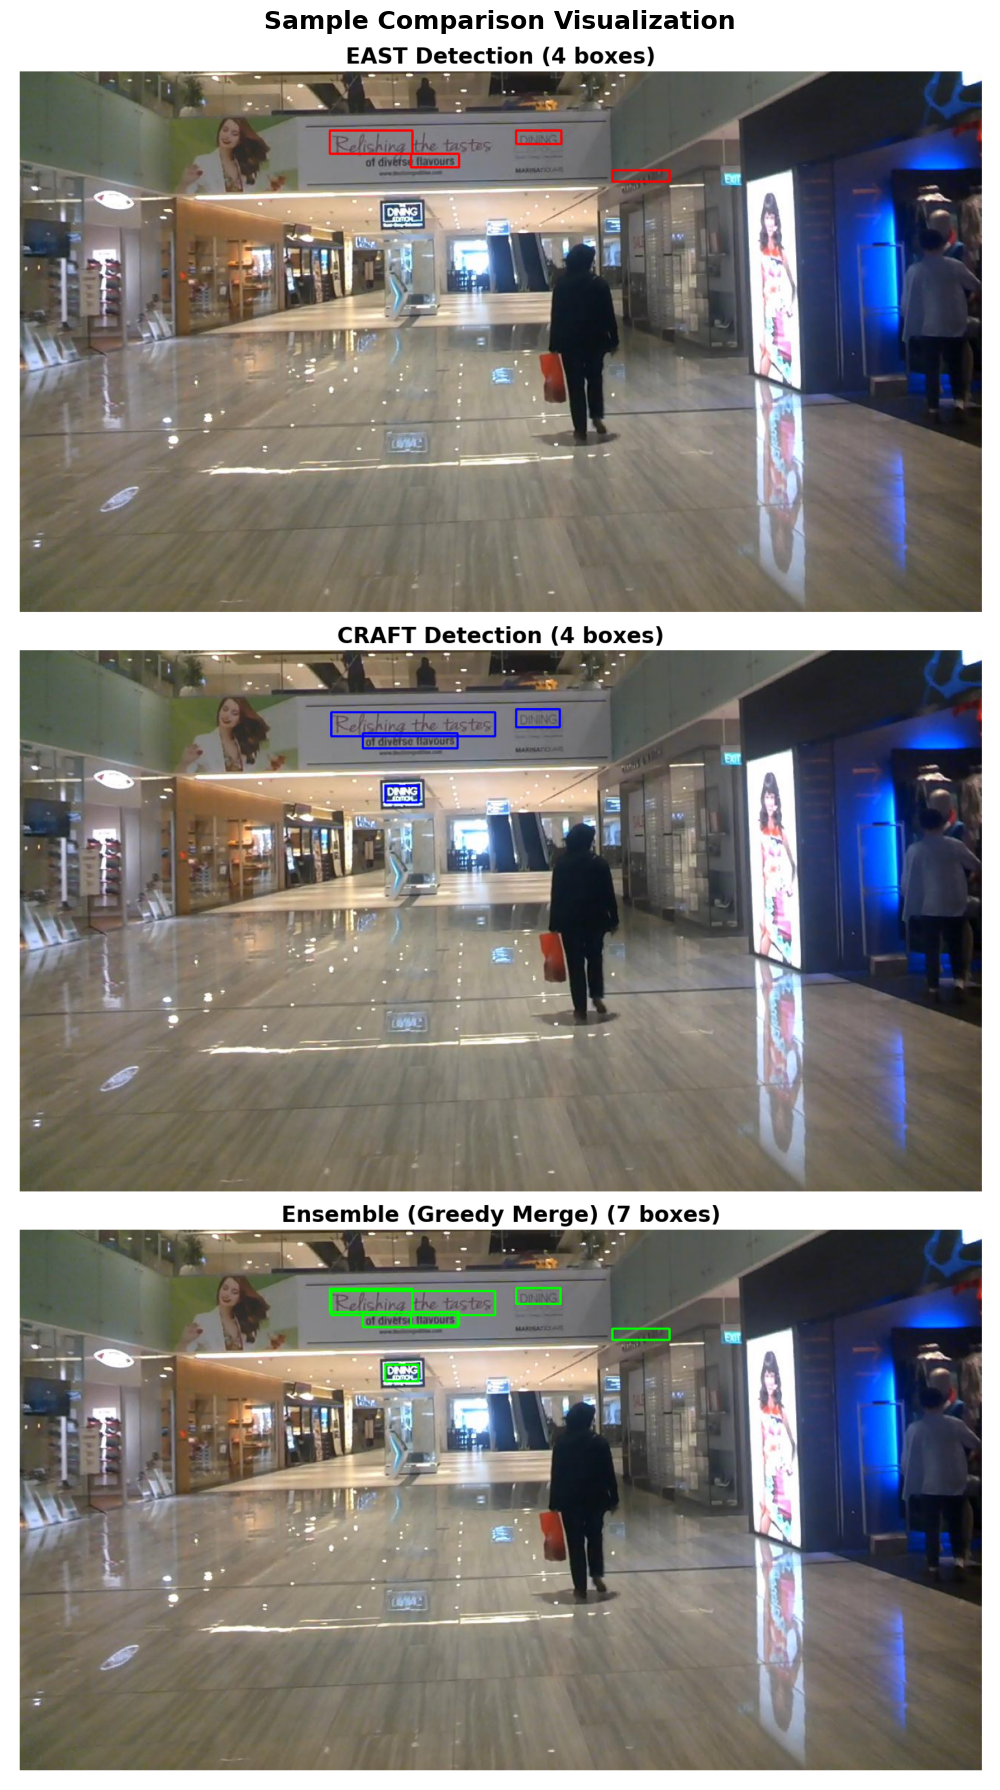


 Displaying: img_100_comparison.png
  All visualizations saved to: greedyfuse_visualizations


In [22]:
# Display first visualization in notebook
if len(list(VIZ_DIR.glob('*.png'))) > 0:
    sample_viz = sorted(VIZ_DIR.glob('*.png'))[0]
    img = plt.imread(sample_viz)
    
    plt.figure(figsize=(15, 18))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Sample Comparison Visualization', fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"\n Displaying: {sample_viz.name}")
    print(f"  All visualizations saved to: {VIZ_DIR}")

Processing: ../archive/ch4_training_images/img_12.jpg
EAST detected: 4 boxes
CRAFT detected: 3 boxes
Ensemble detected: 6 boxes


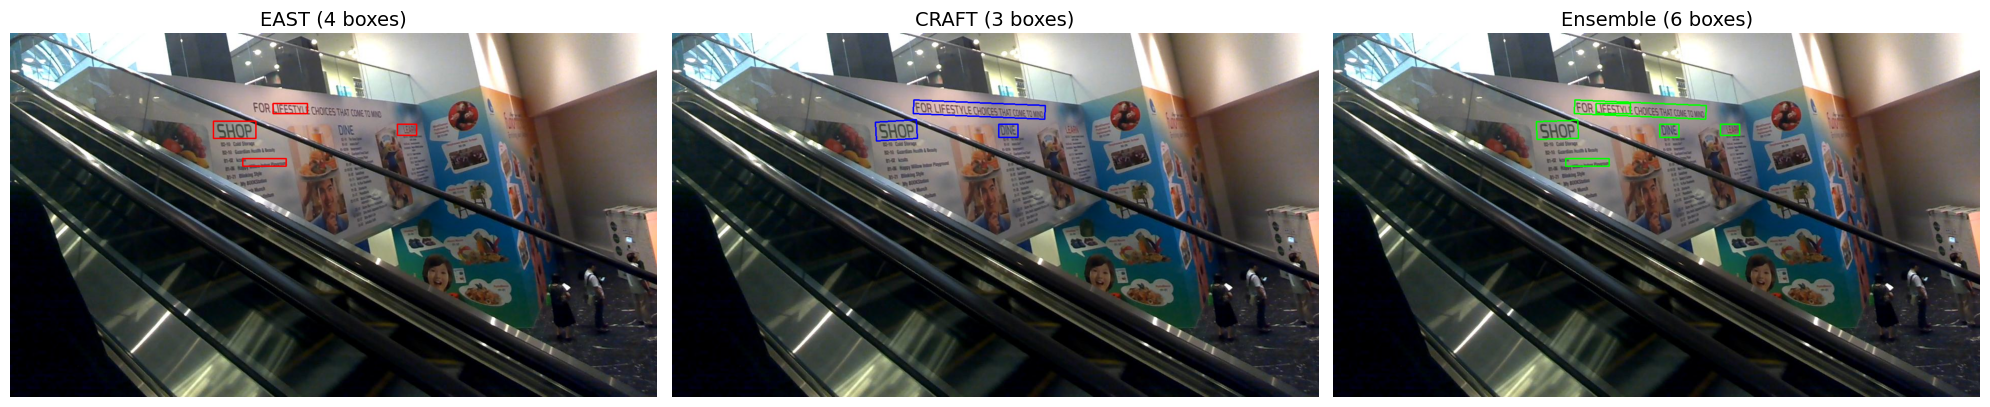

In [23]:
# Specify your image path here
IMAGE_PATH = '../archive/ch4_training_images/img_12.jpg'  # Change this to your image path

# Run detection
print(f"Processing: {IMAGE_PATH}")
image = cv2.imread(IMAGE_PATH)

# Get detections from both models
east_dets = detect_east(IMAGE_PATH, east_net)
craft_dets = detect_craft(IMAGE_PATH, craft_detector)
ensemble_dets = greedy_merge(east_dets, craft_dets)

print(f"EAST detected: {len(east_dets)} boxes")
print(f"CRAFT detected: {len(craft_dets)} boxes")
print(f"Ensemble detected: {len(ensemble_dets)} boxes")

# Visualize results
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_east = draw_detections(image_rgb, east_dets, color=(255, 0, 0), thickness=2)
img_craft = draw_detections(image_rgb, craft_dets, color=(0, 0, 255), thickness=2)
img_ensemble = draw_detections(image_rgb, ensemble_dets, color=(0, 255, 0), thickness=2)

# Display
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes[0].imshow(img_east)
axes[0].set_title(f'EAST ({len(east_dets)} boxes)', fontsize=14)
axes[0].axis('off')

axes[1].imshow(img_craft)
axes[1].set_title(f'CRAFT ({len(craft_dets)} boxes)', fontsize=14)
axes[1].axis('off')

axes[2].imshow(img_ensemble)
axes[2].set_title(f'Ensemble ({len(ensemble_dets)} boxes)', fontsize=14)
axes[2].axis('off')

plt.tight_layout()
plt.show()